# Clustering – Homework

**Overview**

Dataset: https://www.kaggle.com/crawford/20-newsgroups/data

**Evaluation Criteria (max 10 points)**

- EDA (corpus statistics, word lengths distributions, most common words, visualizations with dimensionality reduction, etc) - 1
- Try vectorizations other than TF-IDF (LDA, word2vec, doc2vec, lda2vec, etc) - 2
- Train K-Means assuming the number of clusters is known - 1
- Train K-Means assuming the number of clusters is unknown - 1
- Visualize resulting clusters - 1
- Try algorithms other than K-Means (at least 2, with hyperparameter tuning) - 2
- Evaluate all algorithms using different performance metrics (w/wo class labels) - 2

## Imports

In [451]:
import os
import re
import string
import warnings

from itertools import chain
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from mglearn.tools import discrete_scatter

from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score, silhouette_score
)

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

## Writing utility code

Below is the `scikit-learn` transformer that vectorizes the document by averaging all word embeddings. Additionally, word vectors can be weighted by IDF which is calculated as follows:

$$idf(w, d) = \log{\frac{N + 1}{N_{w} + 1}} + 1$$

where $N$ is the number of documents in the training set, $N_w$ is the number of documents
in the training set that the specific word appears in.

This class is slightly modified version of this code: http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [24]:
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, word2vec: dict, weights: str = None):
        self.word2vec = {k:np.array(v) for k, v in word2vec.items()}
        self.weights = weights

        # If a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors.
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y=None):
        if self.weights == 'idf':
            self.tfidf = TfidfVectorizer(analyzer=lambda x: x).fit(X)
            
            # If a word was never seen - it must be at least as infrequent
            # as any of the known words - so the default idf is the max of 
            # known idf's.
            max_idf = max(self.tfidf.idf_)
            
            for word in self.word2vec.keys():
                if word in self.tfidf.vocabulary_:
                    weight = self.tfidf.idf_[self.tfidf.vocabulary_[word]] 
                else:
                    weight = max_idf
                self.word2vec[word] *= weight
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

def test_mean_embedding_vectorizer():
    X = [
        ['may', 'the', 'force'],
        ['be', 'with', 'you'],
        ['always'],
    ]
    w2v = {'may': [1], 'force': [2], 'with': [3], 'you': [4]}
    vect = MeanEmbeddingVectorizer(w2v)
    result = vect.fit_transform(X)
    expected = np.array([[1.5], [3.5], [0.]])
    assert np.array_equal(result, expected)
    
def test_mean_weighted_embedding_vectorizer():

    X = [
        ['a', 'a', 'b'],
        ['a', 'c', 'c'],
        ['a', 'c'],
    ]
    w2v = {'a': [1., 10.], 'b': [2., 20.], 'c': [3., 30.]}
    vect = MeanEmbeddingVectorizer(w2v, weights='idf')
    result = vect.fit_transform(X)
    expected = np.array([
        [ 1.79543145, 17.95431454],
        [ 2.90869748, 29.08697478],
        [ 2.43152311, 24.31523109]
    ])
    assert np.isclose(result, expected).all()


test_mean_embedding_vectorizer()
test_mean_weighted_embedding_vectorizer()

Now some distance-related functions and metrics:

In [322]:
def get_cluster_centers(X, labels):
    centers = np.empty((0, X.shape[1]))
    for label in np.sort(np.unique(labels)):
        centers = np.vstack([centers, X[labels == label].mean(axis=0)])
    return centers

In [323]:
def avg_inter_cluster_distance(X, cluster_centers, metric='euclidean'):
    return sum(np.min(cdist(X, cluster_centers, metric), axis=1)) / X.shape[0]

In [324]:
def avg_intra_cluster_distance(centers, metric='euclidean'):
    return sum(sum(cdist(centers, centers, metric))) / (centers.shape[0] ** 2)

The rest is plotting/visualization routines:

In [145]:
def plot_contingency_matrix(labels_true, labels_pred, transpose=False):
    labels = np.unique(labels_true)

    matrix = contingency_matrix(labels_true, labels_pred)
    df_cm = pd.DataFrame(matrix, index=labels)
    if transpose:
        df_cm = df_cm.T
    
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
    
    xlabel, ylabel = 'Predicted label', 'True label'
    if transpose:
        plt.xticks(rotation=90)
        xlabel, ylabel = ylabel, xlabel
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title('Contingency matrix\n', fontsize=16, fontweight='bold')
    plt.show()

In [4]:
def print_feature_summary(vectorizer, txt_array):
    """
    Show example features generated by a vectorizer.
    
    """
    feature_names = np.array(vectorizer.get_feature_names())
    X = vectorizer.transform(txt_array)
    sums = np.array(X.sum(axis=0))[0]
    sorted_idx = sums.argsort()

    print('Total features:', len(feature_names))
    print("First 50 features:\n{}".format(feature_names[:50]))
    print("Features with highest count: \n{}".format(
        feature_names[sorted_idx[-50:]]))
    print("Features with lowest count:\n{}".format(
        feature_names[sorted_idx[:50]]))

In [325]:
def visualize_labels(X, labels_true, labels_pred, samples=5000):
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0, hspace=0.5)
    
    if isinstance(labels_true, pd.Series):
        labels_true = labels_true.values
    if isinstance(labels_pred, pd.Series):
        labels_pred = labels_pred.values

    samples = min(len(labels_true), samples)
    idx = np.random.choice(X.shape[0], samples, replace=False)

    axes[0].set_title('True labels', fontsize=16, fontweight='bold')
    axes[1].set_title('Predicted labels', fontsize=16, fontweight='bold')
    
    discrete_scatter(X[idx, 0], X[idx, 1], labels_true[idx], ax=axes[0])
    discrete_scatter(X[idx, 0], X[idx, 1], labels_pred[idx], ax=axes[1])

    axes[0].set_xlabel("First component")
    axes[1].set_xlabel("First component")
    plt.ylabel("Second component")

The class to store metrics values and generate reports. It will be heavily used later.

In [105]:
class ClusteringReport:

    def __init__(self, key_name='Key'):
        self.key_name = key_name
        
        self.models = OrderedDict()
        self.homogeneity_scores = OrderedDict()
        self.avg_inter_cluster_distances = OrderedDict()
        self.avg_intra_cluster_distances = OrderedDict()
        self.completeness_scores = OrderedDict()
        self.v_measure_scores = OrderedDict()
        self.silhouette_scores = OrderedDict()

    
    def add_model(self, key, model, X, labels_true, labels_pred,
                  distance_metric='euclidean'):
        
        self.models[key] = model
        centers = get_cluster_centers(X, labels_pred)
        
        self.avg_inter_cluster_distances[key] = avg_inter_cluster_distance(X, centers,
                                                                           metric=distance_metric)
        self.avg_intra_cluster_distances[key] = avg_intra_cluster_distance(centers, 
                                                                           metric=distance_metric)
        self.homogeneity_scores[key] = homogeneity_score(labels_true, labels_pred)
        self.completeness_scores[key] = completeness_score(labels_true, labels_pred)
        self.v_measure_scores[key] = v_measure_score(labels_true, labels_pred)
        self.silhouette_scores[key] = silhouette_score(X, labels_pred, metric=distance_metric)
        
    def plot_metrics(self):
        f, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 8))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)

        chart_metrics = {
            'Avg inter-cluster distance': self.avg_inter_cluster_distances.values(),
            'Avg intra-cluster distance': self.avg_intra_cluster_distances.values(),
            'Homogeneity score': self.homogeneity_scores.values(),
            'Completeness score': self.completeness_scores.values(),
            'V-measure score': self.v_measure_scores.values(),
            'Silhouette score': self.silhouette_scores.values(),
        }

        for index, (metric_name, metric_values) in enumerate(chart_metrics.items()):
            ax = axes[index // axes.shape[1]][index % axes.shape[1]]
            ax.plot(self.models.keys(), metric_values) #, 'bx-')
            ax.set_title(metric_name, fontsize=14, fontweight='bold')
            ax.set_xlabel(self.key_name)
            ax.set_ylabel(metric_name)
    
    def print_scores(self, key):
        print('Average inter-cluster distance:', self.avg_inter_cluster_distances[key])
        print('Average inter-cluster distance:', self.avg_intra_cluster_distances[key])
        print('Homogeneity score:', self.homogeneity_scores[key])
        print('Completeness score:', self.completeness_scores[key])
        print('V-measure score:', self.v_measure_scores[key])
        print('Silhouette score:', self.silhouette_scores[key])
    
    def as_dataframe(self):
        return pd.DataFrame({
            self.key_name: list(self.models.keys()),
            'Average inter-cluster distance': list(self.avg_inter_cluster_distances.values()),
            'Average intra-cluster distance': list(self.avg_intra_cluster_distances.values()),
            'Homogeneity': list(self.homogeneity_scores.values()),
            'Completeness': list(self.completeness_scores.values()),
            'V-measure': list(self.v_measure_scores.values()),
            'Silhouette': list(self.silhouette_scores.values()),
        })

## Loading the data and EDA

Load files from directory, split files to individual documents (using regular expressions):

In [5]:
DATASET_DIR = 'D:/datasets/20-newsgroups'

HEADER_BLOCK_REGEX = (
    "(?:(?:Newsgroup|>Newsgroups|document_id|From|Subject|Archive-name"
    "|Last-update|Organization|Alt-atheism-archive-name|Last-modified|Version): [^\n]+[\n]+)+"
)

def load_data(data_dir):
    df = pd.DataFrame()
    regex = re.compile(HEADER_BLOCK_REGEX, re.IGNORECASE)
    filenames = filter(lambda x: x.endswith('.txt'), os.listdir(data_dir))

    for filename in filenames:
        label = '.'.join(filename.split('.')[1:])[:-4]     # delete first segment and trim '.txt' extension
        with open(os.path.join(data_dir, filename), encoding="cp1251") as file:
            docs = regex.split(file.read())[1:]    # `[1:]` removes first element which would be empty string
        df = pd.concat([
            df,
            pd.DataFrame({
                'text': docs,
                'label': label,
            })
        ])
    return df

df = load_data(DATASET_DIR)

We can see that dataset is pretty balanced:

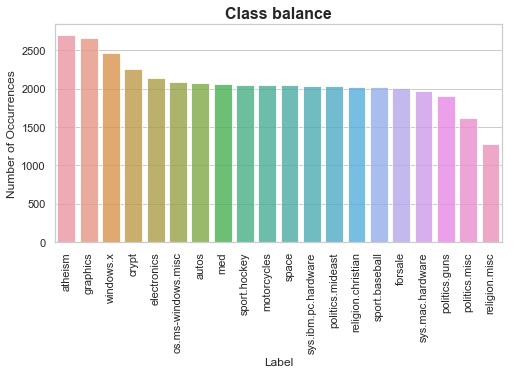

In [320]:
count_label = df['label'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(count_label.index, count_label.values, alpha=0.8)
plt.title('Class balance', fontsize=16, fontweight='bold')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12);
plt.xticks(rotation=90)
plt.show()

Apply basic tokenization, lemmatization, weeding out stop words, punctuation and emails:

In [269]:
email_re = re.compile(r"\S*@\S*\s?")
stop_chars = str.maketrans({key: ' ' for key in string.punctuation})
stop_words = stopwords.words('english') + ['article', 'writes']
tokenizer = RegexpTokenizer(r"(?u)\b[^\W\d][^\W\d]+\b")
lemmer = WordNetLemmatizer()

def preprocessor(text):
    """ Remove email, strip punctuation and convert to lowercase. """
    return email_re.sub('', text).translate(stop_chars).lower()

def lemmed_words(doc):
    """ Split to tokens, ignore stopwords, apply lemmatization. """
    return [
        lemmer.lemmatize(word)
        for word in tokenizer.tokenize(doc)
        if len(word) > 1 and word not in stop_words
    ]

df['words'] = df.text.map(lambda x: lemmed_words(preprocessor(x)))

Drop some garbage (base64 BMP dumps, they contain a lot of `AX` words):

In [386]:
subset = df[df.label == 'os.ms-windows.misc']
subset['ax_count'] = subset.words.apply(lambda x: Counter(x)['ax'])
df.drop(subset[subset.ax_count > 1000].index, inplace=True)

y = df.label

Now let's inspect some basic statistical properties (like lengths distribution). However, they will not be used for clustering, it is done for the sake of exercise.

In [387]:
def add_features(df):
    df['length_log'] = df['text'].apply(len).apply(np.log)
    df['punct_log'] = df['text'].apply(lambda x: len([c for c in x if c in string.punctuation])).apply(np.log)
    
add_features(df)    

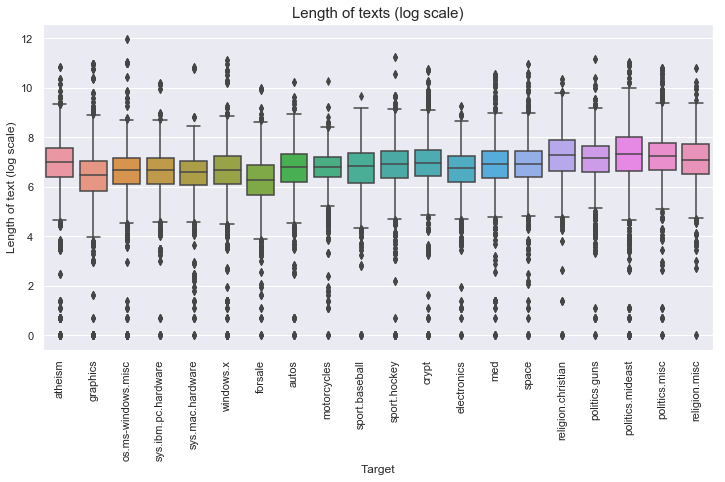

In [388]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='length_log', data=df)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Length of text (log scale)', fontsize=12)
plt.title("Length of texts (log scale)", fontsize=15)
plt.xticks(rotation=90)
plt.show()

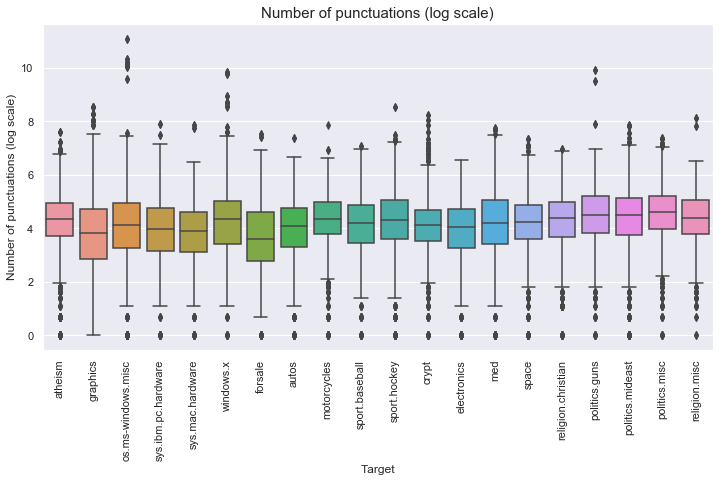

In [389]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='punct_log', data=df)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Number of punctuations (log scale)', fontsize=12)
plt.title("Number of punctuations (log scale)", fontsize=15)
plt.xticks(rotation=90)
plt.show()

Let's take a look at the top most popular words for each topic:

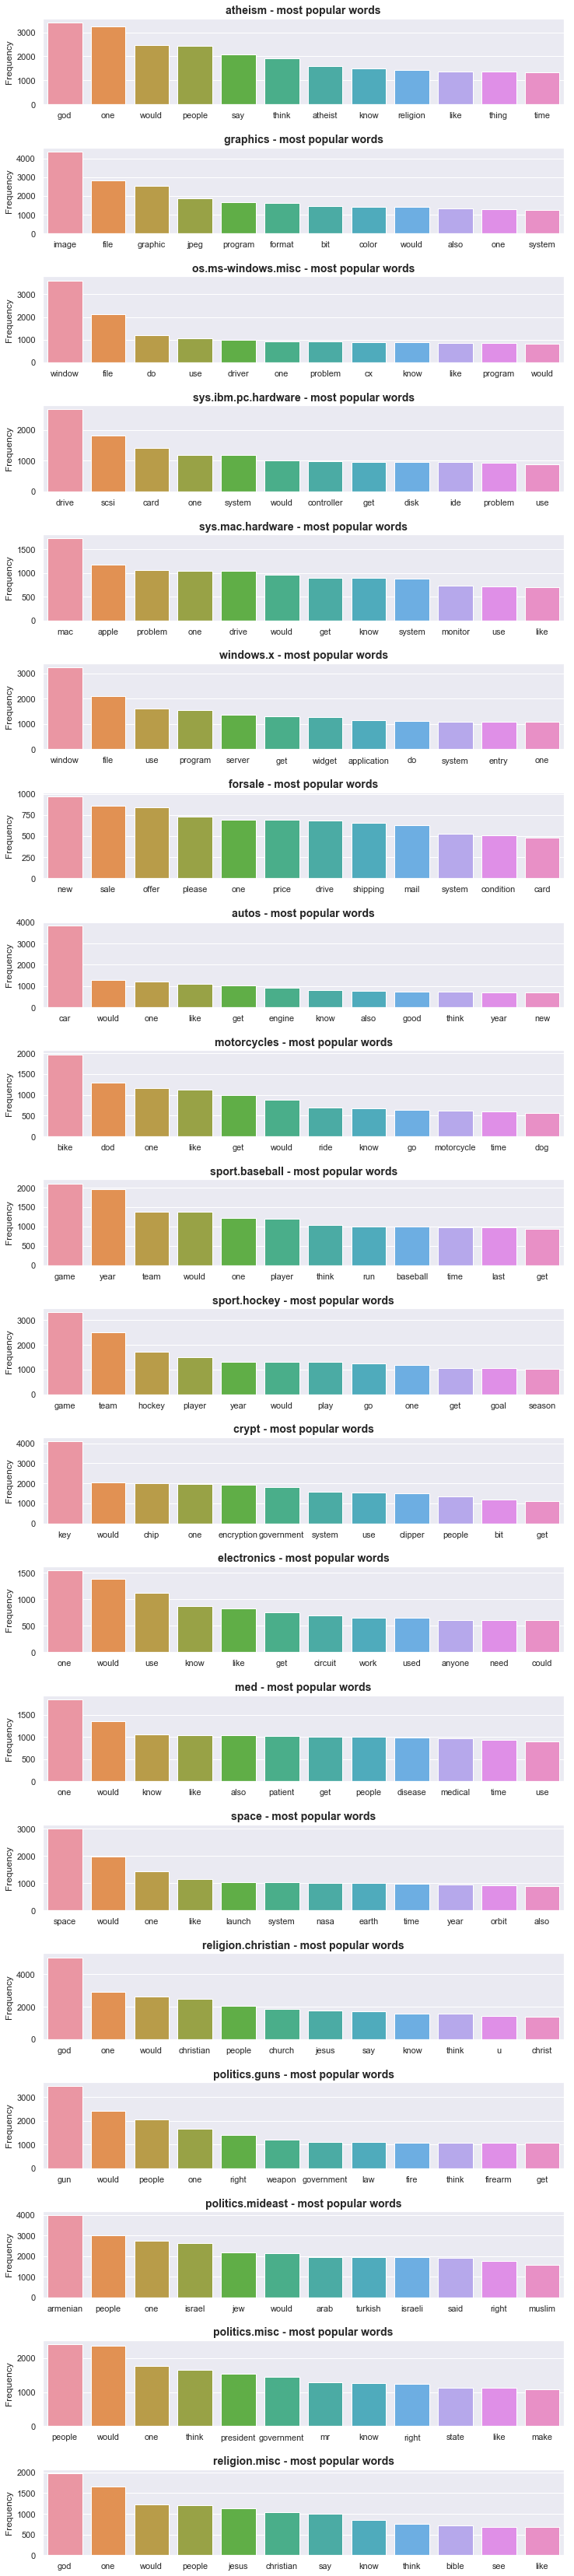

In [390]:
n_words = 12
labels = df['label'].unique()

f, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=(12, 3 * len(labels)))
plt.subplots_adjust(hspace=0.5)

for index, label in enumerate(labels):
    words = list(chain.from_iterable(df[df.label == label].words))
    word_dist = nltk.FreqDist(words)
    word_df = pd.DataFrame(word_dist.most_common(n_words), columns=['Word', 'Frequency'])

    ax = axes[index]
    sns.barplot(x="Word",y="Frequency", data=word_df.head(n_words), ax=ax)
    ax.set_title('%s - most popular words' % label, fontsize=14, fontweight='bold')
    ax.set_xlabel("")
    
plt.show()

**Conclusion:**
- Clustering performance is hard to predict from this plots. But we could expect the algorith to group these documents into some broad clusters (sports, politics, computers). More detailed distinction will be problematic.
- We have several "noisy" clusters (e.g. "electronic", "space")
- EDA helped us clean dataset a little bit (e.g. remove binary dumps)

## Vectorizations

We will try the following:
- LSA (TF-IDF + SVD)
- Word2vec average
- IDF-weighted Word2vec average

### LSA

In [441]:
pipe = Pipeline(steps=[
    ('bag', CountVectorizer(analyzer=lambda x:x, min_df=50, max_df=0.8)),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=10)),
])

X_lsa = pipe.fit_transform(df['words'])

In [443]:
X_lsa_tsne = TSNE(n_components=2).fit_transform(X_lsa)

### Word2vec

In [28]:
def load_embeddings(filename):
    with open(filename, "r", encoding="utf-8") as lines:
        w2v = {
            line.split()[0]: np.array(list(map(float, line.split()[1:])))
            for line in lines
        }
    return w2v

word2vec = load_embeddings('D:/models/glove.6B/glove.6B.50d.txt')

In [32]:
pipe = Pipeline(steps=[
    ('word2vec', MeanEmbeddingVectorizer(word2vec)),
    ('pca', PCA(n_components=10)),
    ('std', StandardScaler()),
])

X_w2v = pipe.fit_transform(df.words)

In [33]:
X_w2v_tsne = TSNE(n_components=2).fit_transform(X_w2v)

###  Word2vec (IDF-weighted)

In [34]:
pipe = Pipeline(steps=[
    ('word2vec', MeanEmbeddingVectorizer(word2vec, weights='idf')),
    ('pca', PCA(n_components=10)),
    ('std', StandardScaler()),
])

X_w2v_idf = pipe.fit_transform(df.words)

In [35]:
X_w2v_idf_tsne = TSNE(n_components=2).fit_transform(X_w2v_idf)

## K-Means: choosing vectorization

Now let's try K-Means to choose best vectorization for the text (assuming we know the number of clusters). That vectorization will be used for all further models and searches (though it may not be best for all models).

Key points:
- LSA wins by far (better silhouette and v-measure scores)
- Distance-related metrics in different feature spaces are not comparable and thus not used.

In [ ]:
reports = {}

In [394]:
report = ClusteringReport(key_name='Vectorization')

In [395]:
%%time
X = X_lsa
model = KMeans(n_clusters=20, n_jobs=4).fit(X)
report.add_model('LSA', model, X, y, model.labels_)

Wall time: 26.3 s


In [396]:
%%time
X = X_w2v
model = KMeans(n_clusters=20, n_jobs=4).fit(X)
report.add_model('Word2vec', model, X, y, model.labels_)

Wall time: 31.6 s


In [397]:
%%time
X = X_w2v_idf
model = KMeans(n_clusters=20, n_jobs=4).fit(X)
report.add_model('Word2vec * IDF', model, X, y, model.labels_)

Wall time: 32.1 s


In [400]:
reports['kmeans_vectorization'] = report
reports['kmeans_vectorization'].as_dataframe()[['Vectorization', 'V-measure', 'Silhouette']]

,Vectorization,V-measure,Silhouette
0,LSA,0.375285,0.204621
1,Word2vec,0.309650,0.115709
2,Word2vec * IDF,0.332012,0.123190


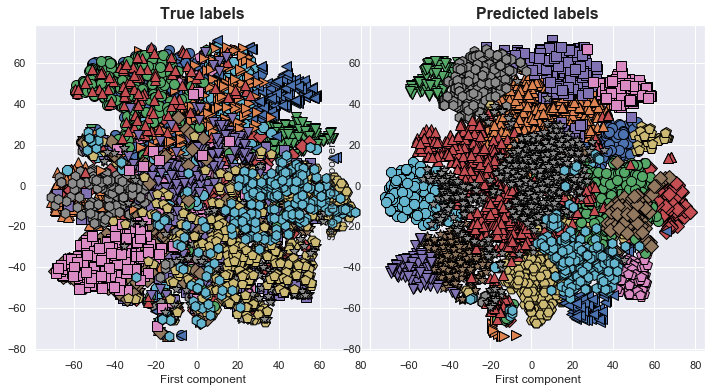

In [138]:
visualize_labels(X_lsa_tsne, df.label, reports['kmeans_vectorization'].models['LSA'].labels_)

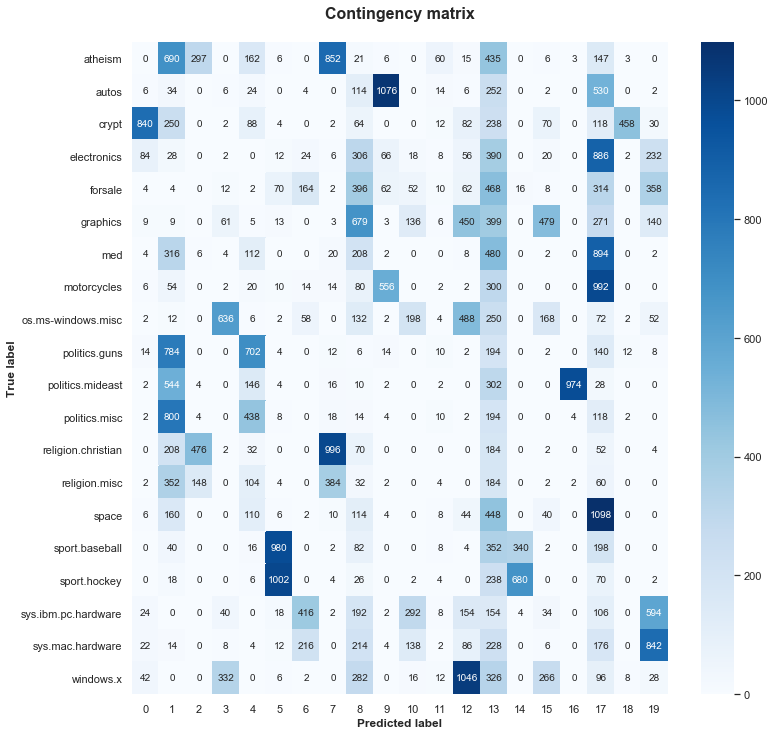

In [139]:
plt.figure(figsize=(12, 12))
plot_contingency_matrix(df.label, reports['kmeans_vectorization'].models['LSA'].labels_)

## K-Means: tuning the number of clusters

Having chosen vectorization let's try to determine the number of clusters for K-Means (assuming we don't know it beforehead).

In [140]:
%%time

report = ClusteringReport(key_name='Number of clusters')
X = X_lsa

for num_clusters in range(2, 31):
    model = KMeans(n_clusters=num_clusters, random_state=0, n_jobs=4).fit(X)
    report.add_model(num_clusters, model, X, y, model.labels_)

Wall time: 12min 54s


In [141]:
reports['kmeans_tuning'] = report
report.as_dataframe()

,Number of clusters,Average inter-cluster distance,Average intra-cluster distance,Homogeneity,Completeness,V-measure,Silhouette
0,2,0.148019,0.071630,0.102685,0.508415,0.170861,0.195071
1,3,0.139769,0.140261,0.137670,0.505583,0.216411,0.215188
2,4,0.132176,0.168143,0.176303,0.504680,0.261318,0.213619
3,5,0.125592,0.187209,0.209459,0.483538,0.292299,0.214920
4,6,0.120703,0.229017,0.216257,0.481007,0.298369,0.232002
5,7,0.116242,0.252959,0.232633,0.489163,0.315312,0.227159
6,8,0.113979,0.345162,0.233965,0.484360,0.315521,0.238565
7,9,0.108272,0.335753,0.250912,0.442704,0.320292,0.237995
8,10,0.103894,0.324792,0.275282,0.435273,0.337265,0.236705
9,11,0.100406,0.323360,0.275675,0.413207,0.330713,0.240087


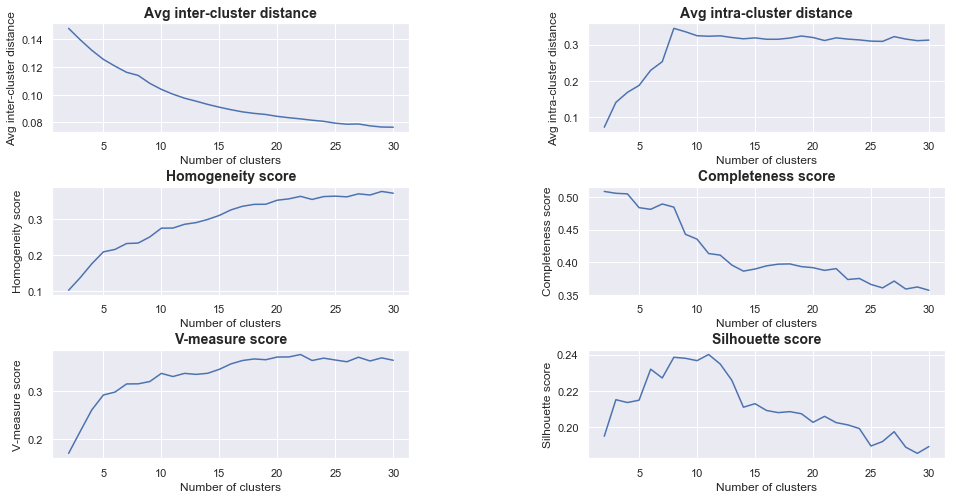

In [142]:
reports['kmeans_tuning'].plot_metrics()

**Chosen number of clusters: 11**

In [146]:
reports['kmeans_tuning'].models[11].print_scores(11)

Average inter-cluster distance: 0.10040590774574228
Average inter-cluster distance: 0.3233596109576153
Homogeneity score: 0.275675334633461
Completeness score: 0.4132073488238912
V-measure score: 0.3307125491624686
Silhouette score: 0.24008701659090284


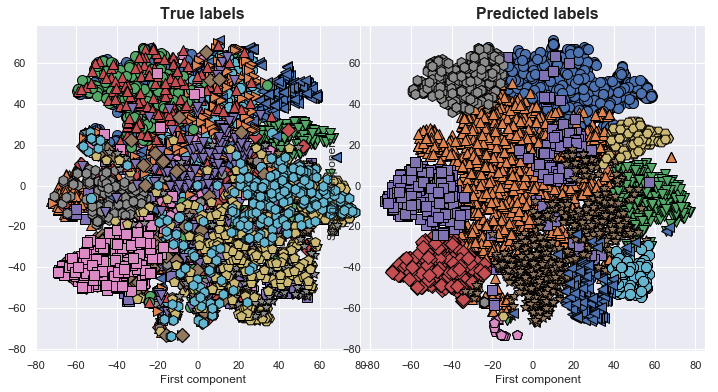

In [147]:
visualize_labels(X_lsa_tsne, df.label, reports['kmeans_tuning'].models[11].labels_)

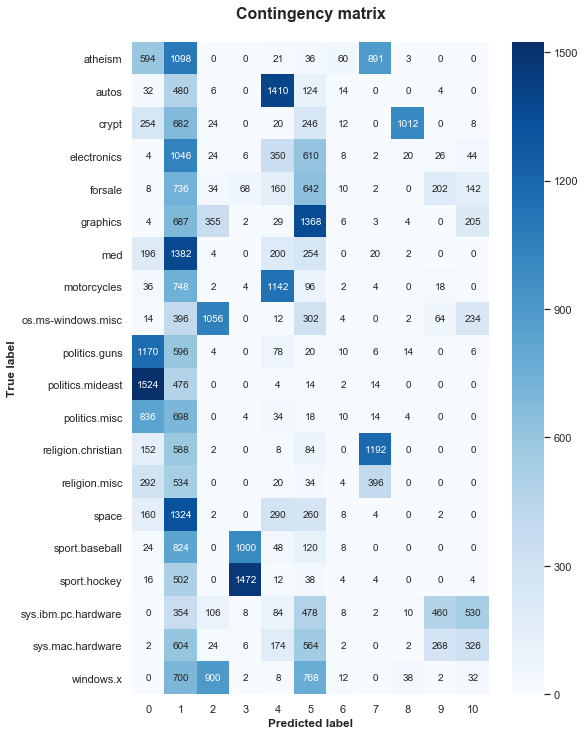

In [153]:
plt.figure(figsize=(8, 12))
plot_contingency_matrix(df.label, reports['kmeans_tuning'].models[11].labels_)

**Conclusion**:
- 11 clusters detected (using elbow method on silhouette score plot)
- There's one prominent noise cluster. My guess that it is some sort of indistinguishable mixture, an intersection that lies in the "central" zone of the blob.
- Aside from noise cluster we have very nice broad categories - sports, religion, computers, etc.

## DBSCAN


Key points:
- The same LSA vectorization is used
- Initial value of **min_samples** was chosen to be slighly greater than number of dimensions in the data
- Initial value of **epsilon** was chosen by looking at k-distance plot and using "elbow" method
- Performance is completely unacceptable here. The algorithm either joins everything in one cluster or considers all points to be outliers. There's no middle ground, no matter what. Most probably it is because of great differences in density in the vector space.

Below is the code that was used (parameter tuning is skipped).

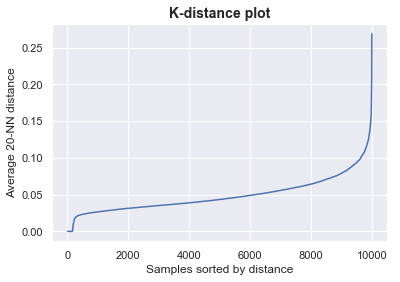

In [154]:
from sklearn.neighbors import NearestNeighbors

def k_distance_plot(X, n_neighbors, metric='euclidean', n_samples=10000):
    idx = np.random.choice(X.shape[0], n_samples, replace=False)
    X = X[idx]
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=7).fit(X)
    distances, _ = knn.kneighbors(X)
    distances = np.sort(np.average(distances, axis=1))
    plt.plot(distances)
    plt.title('K-distance plot', fontsize=14, fontweight='bold')
    plt.xlabel('Samples sorted by distance')
    plt.ylabel('Average %d-NN distance' % n_neighbors)

k_distance_plot(X_lsa, 20)

In [160]:
%%time
model = DBSCAN(eps=0.10, min_samples=12, n_jobs=4).fit(X_lsa)

outliers_total = len(model.labels_[model.labels_ == -1])
outliers_percentage = outliers_total * 100 / X.shape[0]
print('Number of clusters: ', len(np.unique(model.labels_)))
print('Outliers: %d (%.2f%%)' % (outliers_total, outliers_percentage))

Number of clusters:  3
Outliers: 375 (0.90%)
Wall time: 15.7 s


In [161]:
report = ClusteringReport()
report.add_model(None, model, X, y, model.labels_)
reports['dbscan'] = report

In [162]:
reports['dbscan'].print_scores(None)

Average inter-cluster distance: 0.1533159817811527
Average inter-cluster distance: 0.21314188276235668
Homogeneity score: 0.0016925949831824547
Completeness score: 0.09325982344410098
V-measure score: 0.003324846526470571
Silhouette score: 0.40155899690994484


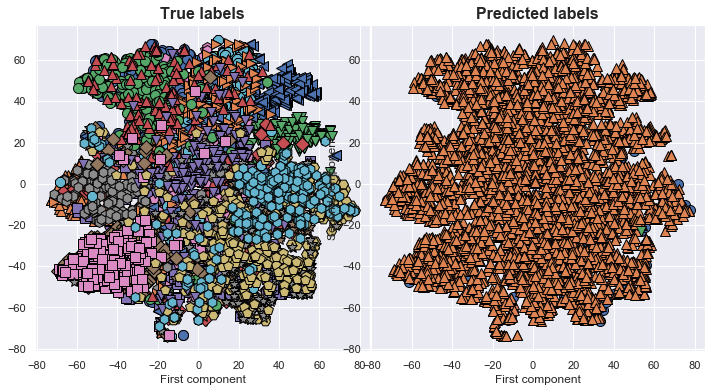

In [164]:
visualize_labels(X_lsa_tsne, df.label, reports['dbscan'].models[None].labels_)

## Agglomerative clustering

Key points:
- We are using the same LSA features
- First we build the whole tree
- Then we take a look at the dendrogram or use elbow method to choose the number of clusters

Below are the code and the charts.

Dendrogram-plotting code can be found in `sklearn` examples: https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py

In [414]:
def plot_dendrogram(model, **kwargs):
    plt.figure(figsize=(16, 8))
    plt.title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [442]:
%%time
X = X_lsa
report = ClusteringReport(key_name='Number of clusters')
for n_clusters in range(2, 31):
    model = AgglomerativeClustering(n_clusters=n_clusters, memory='model_cache')
    model.fit(X)
    report.add_model(n_clusters, model, X, df['label'], model.labels_)

reports['agglomerative'] = report

Wall time: 13min 47s


Wall time: 452 ms


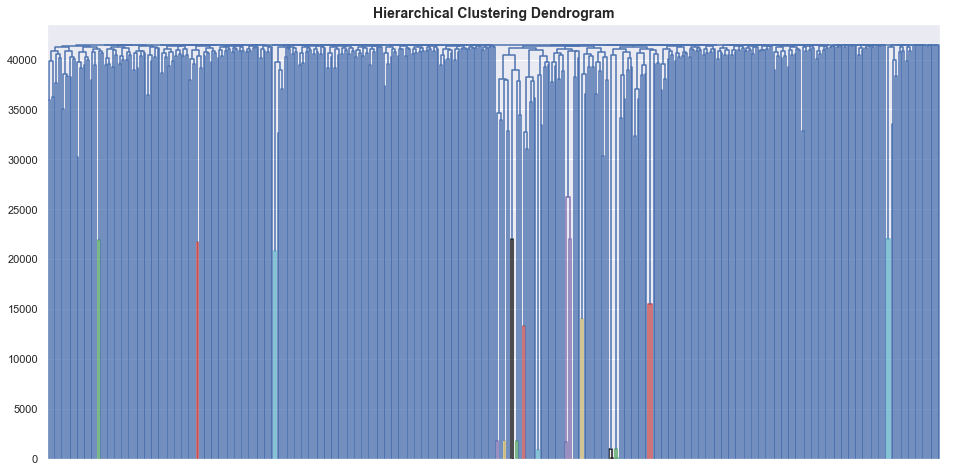

In [427]:
%%time
plot_dendrogram(reports['agglomerative'].models[2], no_labels=True, truncate_mode='level', p=8)

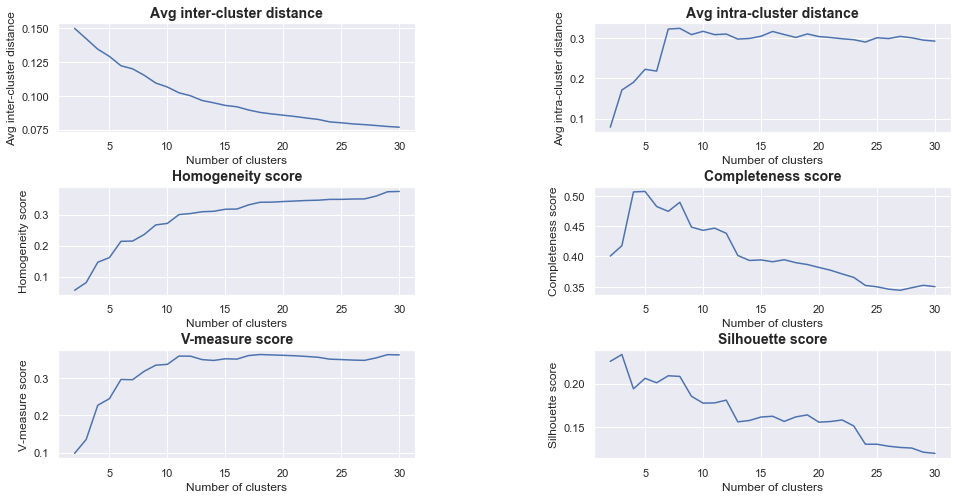

In [428]:
reports['agglomerative'].plot_metrics()

**Chosen number of clusters: 7**

In [447]:
reports['agglomerative'].print_scores(7)

Average inter-cluster distance: 0.12038695678928817
Average inter-cluster distance: 0.3483645580338666
Homogeneity score: 0.2290238419989893
Completeness score: 0.5153904882244041
V-measure score: 0.31712637693975054
Silhouette score: 0.21401706582892072


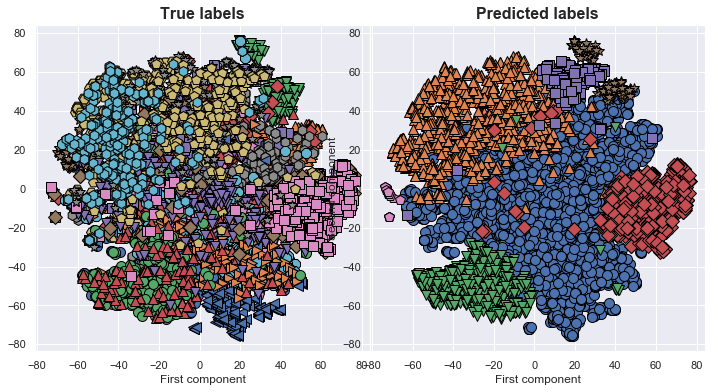

In [448]:
visualize_labels(X_lsa_tsne, df['label'], reports['agglomerative'].models[7].labels_)

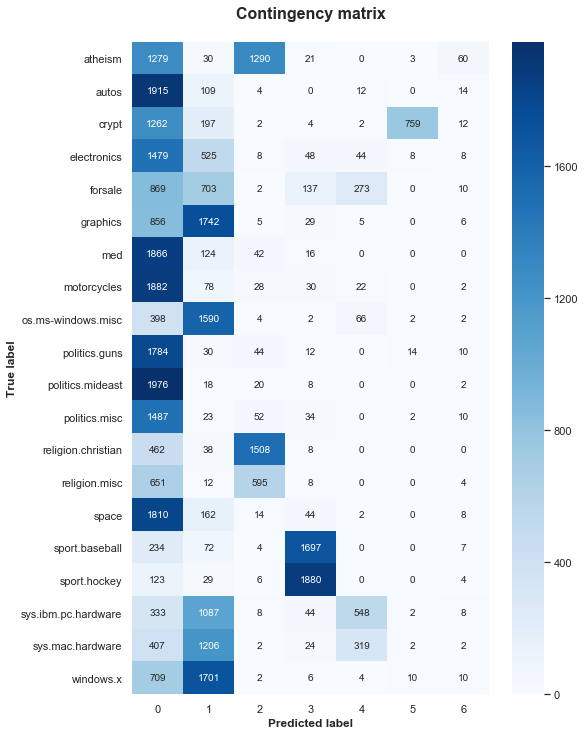

In [449]:
plt.figure(figsize=(8, 12))
plot_contingency_matrix(df['label'], reports['agglomerative'].models[7].labels_)

**Conclusion**:
- 7 clusters were detected (using elbow method on silhouette score plot). Yet this score was misleading. V-measure plot would suggest choosing 11 clusters instead of 7 (like in K-Means). But class labels are not generally available.
- Dendrogram is misleading as well

## Overall summary

- K-Means with LSA gives the best result so far (clusters the documents into 11 broad topics). Yet there's a large noisy blob it is unable to separate.
- Using DBSCAN does not make any sense here (most likely because of the large variations in density)
- Agglomerative clustering would gives results similar to K-Means if we knew number of clusters beforehand (tuning this parameter is complicated because of the misleading metrics).
- Results achieved with Word2vec are worse or (sometimes) close to LSA. Weighting embeddings with IDF or using cosine similarity metric for clustering algorithms does not make much difference. Yet some of the code proving these statements is omitted.
- Perhaps we could do better by tuning dimensionality reduction (10 dimensions were for performance reasowithprobably g